In [1]:
def general_conv2d(inputconv, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="conv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):
        conv = tf.contrib.layers.conv2d(inputconv, o_d, f_w, s_w, padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        conv = tf.nn.relu(conv,"relu")
        return conv

def general_deconv2d(inputconv, outshape, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="deconv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):
        conv = tf.contrib.layers.conv2d_transpose(inputconv, o_d, [f_h, f_w], [s_h, s_w], padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        conv = tf.nn.relu(conv,"relu")
        return conv
    
def build_resnet_block(inputres, dim, name="resnet"):
    with tf.variable_scope(name):
        out_res = tf.pad(inputres, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c1")
        out_res = tf.pad(out_res, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c2",do_relu=False)
        return tf.nn.relu(out_res + inputres)
    

In [2]:
def generator(inputgen, name="generator"):
    with tf.variable_scope(name):
        f = 7
        ks = 3
        ngf = 64

        pad_input = tf.pad(inputgen,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
        o_c1 = general_conv2d(pad_input, ngf, f, f, 1, 1, 0.02,name="c1")
        o_c2 = general_conv2d(o_c1, ngf*2, ks, ks, 2, 2, 0.02,"SAME","c2")
        o_c3 = general_conv2d(o_c2, ngf*4, ks, ks, 2, 2, 0.02,"SAME","c3")

        o_r1 = build_resnet_block(o_c3, ngf*4, "r1")
        o_r2 = build_resnet_block(o_r1, ngf*4, "r2")
        o_r3 = build_resnet_block(o_r2, ngf*4, "r3")
        o_r4 = build_resnet_block(o_r3, ngf*4, "r4")
        o_r5 = build_resnet_block(o_r4, ngf*4, "r5")
        o_r6 = build_resnet_block(o_r5, ngf*4, "r6")

        o_c4 = general_deconv2d(o_r6, [1,64,64,ngf*2], ngf*2, ks, ks, 2, 2, 0.02,"SAME","c4")
        o_c5 = general_deconv2d(o_c4, [1,128,128,ngf], ngf, ks, ks, 2, 2, 0.02,"SAME","c5")
        o_c5_pad = tf.pad(o_c5,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
        o_c6 = general_conv2d(o_c5_pad, 3, f, f, 1, 1, 0.02,"VALID","c6",do_relu=False)

        # Adding the tanh layer

        out_gen = tf.nn.tanh(o_c6,"t1")


        return out_gen

In [3]:
def discriminator(inputdisc, name="discriminator"):
    with tf.variable_scope(name):
        f = 4
        ndf = 64

        o_c1 = general_conv2d(inputdisc, ndf, f, f, 2, 2, 0.02, "SAME", "c1", do_norm=False, relufactor=0.2)
        o_c2 = general_conv2d(o_c1, ndf*2, f, f, 2, 2, 0.02, "SAME", "c2", relufactor=0.2)
        o_c3 = general_conv2d(o_c2, ndf*4, f, f, 2, 2, 0.02, "SAME", "c3", relufactor=0.2)
        o_c4 = general_conv2d(o_c3, ndf*8, f, f, 1, 1, 0.02, "SAME", "c4",relufactor=0.2)
        o_c5 = general_conv2d(o_c4, 1, f, f, 1, 1, 0.02, "SAME", "c5",do_norm=False,do_relu=False)

        return o_c5

In [4]:
def gen_image_pool(num_gens, genimg, gen_pool):
    ''' This function saves the generated image to corresponding pool of images.
    In starting. It keeps on feeling the pool till it is full and then randomly selects an
    already stored image and replace it with new one.'''
    pool_size = 50
    if(num_gens < pool_size):
        gen_pool[num_gens] = genimg
        return genimg
    else :
        p = random.random()
        if p > 0.5:
            random_id = random.randint(0,pool_size-1)
            temp = gen_pool[random_id]
            gen_pool[random_id] = genimg
            return temp
        else :
            return genimg

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import random

train_a_files = tf.train.match_filenames_once("/Users/zjucx/Documents/Github/GAN/dataset/input/monet2photo/trainA/*.jpg")    
train_b_files = tf.train.match_filenames_once("/Users/zjucx/Documents/Github/GAN/dataset/input/monet2photo/trainB/*.jpg")    


train_a_queue = tf.train.string_input_producer(train_a_files)
train_b_queue = tf.train.string_input_producer(train_b_files)


image_reader = tf.WholeFileReader()
_, image_a = image_reader.read(train_a_queue)
_, image_b = image_reader.read(train_b_queue)

image_A = tf.subtract(tf.div(tf.image.resize_images(tf.image.decode_jpeg(image_a),[256,256]),127.5),1)
image_B = tf.subtract(tf.div(tf.image.resize_images(tf.image.decode_jpeg(image_b),[256,256]),127.5),1)


input_A = tf.placeholder(tf.float32, [1, 256, 256, 3], name="input_A")
input_B = tf.placeholder(tf.float32, [1, 256, 256, 3], name="input_B")

gen_A_pool = tf.placeholder(tf.float32, [None, 256, 256, 3], name="gen_A_pool")
gen_B_pool = tf.placeholder(tf.float32, [None, 256, 256, 3], name="gen_B_pool")

with tf.variable_scope("Model") as scope:
    gena = generator(input_B, name="g_B")
    genb = generator(input_A, name="g_A")
    dica = discriminator(input_A, name="d_A")
    dicb = discriminator(input_B, name="d_B")
    
    scope.reuse_variables()
    
    cyca = generator(genb, name="g_B")
    cycb = generator(gena, name="g_A")
    dic_gana = discriminator(gena, name="d_A")
    dic_ganb = discriminator(genb, name="d_B")
    
    scope.reuse_variables()

    dic_gen_A_pool = discriminator(gen_A_pool, "d_A")
    dic_gen_B_pool = discriminator(gen_B_pool, "d_B")

d_loss_a = (tf.reduce_mean(tf.squared_difference(dica, 1)) + tf.reduce_mean(tf.square(dic_gen_A_pool)))/2
d_loss_b = (tf.reduce_mean(tf.squared_difference(dicb, 1)) + tf.reduce_mean(tf.square(dic_gen_B_pool)))/2

cyc_loss = tf.reduce_mean(tf.abs(input_A-cyca)) + tf.reduce_mean(tf.abs(input_B-cycb))

g_loss_a = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(dic_gen_A_pool, 1))
g_loss_b = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(dic_gen_B_pool, 1))

optimizer = tf.train.AdamOptimizer(0.0002, beta1=0.5)

model_vars = tf.trainable_variables()
d_A_vars = [var for var in model_vars if 'd_A' in var.name]
g_A_vars = [var for var in model_vars if 'g_A' in var.name]
d_B_vars = [var for var in model_vars if 'd_B' in var.name]
g_B_vars = [var for var in model_vars if 'g_B' in var.name]

d_A_trainer = optimizer.minimize(d_loss_a, var_list=d_A_vars)
d_B_trainer = optimizer.minimize(d_loss_b, var_list=d_B_vars)
g_A_trainer = optimizer.minimize(g_loss_a, var_list=g_A_vars)
g_B_trainer = optimizer.minimize(g_loss_b, var_list=g_B_vars)

#for var in model_vars: print(var.name)

with tf.control_dependencies([g_A_trainer, d_B_trainer, g_B_trainer, d_A_trainer]):
      optimizers = tf.no_op(name='optimizers')

epoch:0 idx:0 g_A_trainer:10.453290 d_B_trainer:0.498302 g_B_trainer:10.453310 d_A_trainer0.496262


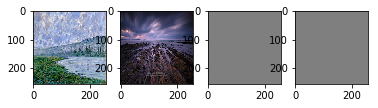

epoch:0 idx:1 g_A_trainer:11.385317 d_B_trainer:0.382783 g_B_trainer:11.386234 d_A_trainer0.413938


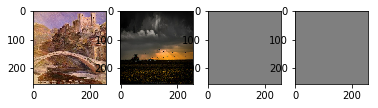

epoch:0 idx:2 g_A_trainer:8.837125 d_B_trainer:0.264936 g_B_trainer:8.842027 d_A_trainer0.257036


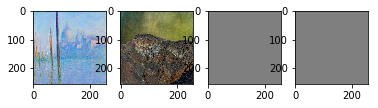

epoch:0 idx:3 g_A_trainer:10.725960 d_B_trainer:0.172494 g_B_trainer:10.750500 d_A_trainer0.041757


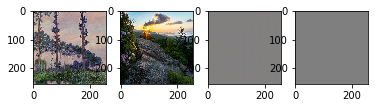

epoch:0 idx:4 g_A_trainer:13.270810 d_B_trainer:0.070547 g_B_trainer:13.540090 d_A_trainer1.093371


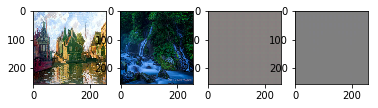

epoch:0 idx:5 g_A_trainer:7.033303 d_B_trainer:0.165723 g_B_trainer:7.406797 d_A_trainer0.373179


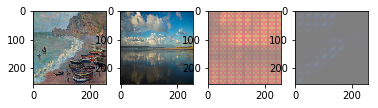

epoch:0 idx:6 g_A_trainer:8.847824 d_B_trainer:0.190747 g_B_trainer:8.716812 d_A_trainer0.357581


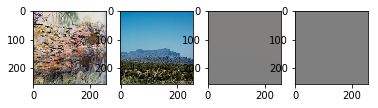

epoch:0 idx:7 g_A_trainer:9.695649 d_B_trainer:0.127063 g_B_trainer:9.653098 d_A_trainer0.334165


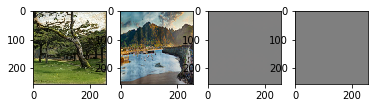

epoch:0 idx:8 g_A_trainer:11.178182 d_B_trainer:0.035772 g_B_trainer:11.138163 d_A_trainer0.297792


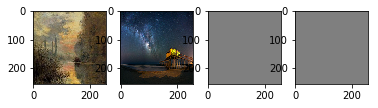

In [ ]:
gena_pool = np.zeros((50, 1, 256, 256, 3))
genb_pool = np.zeros((50, 1, 256, 256, 3))

A_input = np.zeros((100, 1, 256, 256, 3))
B_input = np.zeros((100, 1, 256, 256, 3))

with tf.Session() as sess:
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    
    # Loading images into the tensors
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for idx in range(0, 100):
        imga = sess.run(image_A).reshape((1, 256, 256, 3))
        imgb = sess.run(image_B).reshape((1, 256, 256, 3))
        A_input[idx] = imga
        B_input[idx] = imgb
    coord.request_stop()
    coord.join(threads)
    
    num_gen_inputs = 0
    
    for epoch in range(0,101):
        for idx in range(0, 100):
            imggenb, imggena = sess.run([genb, gena],feed_dict={input_A:A_input[idx], input_B:B_input[idx]})
            
            # train
            _, a, b, c, d = (
                  sess.run(
                      [optimizers, g_loss_a, d_loss_b, g_loss_b, d_loss_a],
                      feed_dict={input_A:A_input[idx], input_B:B_input[idx],
                                 gen_A_pool: gen_image_pool(num_gen_inputs, imggena, gena_pool),
                                 gen_B_pool: gen_image_pool(num_gen_inputs, imggenb, genb_pool)}
                  )
            )
            num_gen_inputs += 1
            # Optimizing the G_A network
            #_, a, imggena, imggenb = sess.run([g_A_trainer, g_loss_a, genb, gena],feed_dict={input_A:A_input[idx], input_B:B_input[idx]})
            #_, b = sess.run([d_B_trainer, d_loss_b],feed_dict={input_A:A_input[idx], input_B:B_input[idx]})
            #_, c = sess.run([g_B_trainer, g_loss_b],feed_dict={input_A:A_input[idx], input_B:B_input[idx]})
            #_, d = sess.run([d_A_trainer, d_loss_a],feed_dict={input_A:A_input[idx], input_B:B_input[idx]})

            print("epoch:%d idx:%d g_A_trainer:%f d_B_trainer:%f g_B_trainer:%f d_A_trainer%f"%(epoch, idx, a, b, c, d))
            plt.subplot(141); plt.imshow(((A_input[idx].reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(142); plt.imshow(((B_input[idx].reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(143); plt.imshow(((imggena.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(144); plt.imshow(((imggenb.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.show()